# Analysis of the Similarity of the Latents

In [1]:
### used to set the interpreter searching path
import sys
target_path = '/home/jovyan/ulmo/'
sys.path.append(target_path)

In [59]:
%matplotlib inline

from importlib import reload
import os
import numpy as np
from pkg_resources import resource_filename

import pandas

import h5py
import seaborn as sns
import pandas as pd
from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.ssl.train_util import modis_loader, set_model
from ulmo.ssl.train_util import Params, option_preprocess
from ulmo.ssl import latents_extraction

import torch

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import trange

In [3]:
llc_modis_2012_data_path = "/home/jovyan/ulmo/ulmo/runs/SSL/experiments/datasets/llc_dataset/"
llc_modis_2012_data = os.path.join(llc_modis_2012_data_path, os.listdir(llc_modis_2012_data_path)[1])

In [4]:
with h5py.File(llc_modis_2012_data, 'r') as f:
    llc_modis_2012 = f['valid'][:]

In [5]:
print(llc_modis_2012.shape)

(635295, 1, 64, 64)


In [6]:
llc_modis_2012_latents_path = "/home/jovyan/ulmo/ulmo/runs/SSL/llc_ssl/experiments/LLC_MODIS_2012_latents/"
llc_modis_2012_latents = os.path.join(llc_modis_2012_latents_path, os.listdir(llc_modis_2012_latents_path)[1])

In [7]:
with h5py.File(llc_modis_2012_latents, 'r') as f:
    latents_llc_modis_2012 = f['valid'][:]

In [8]:
latents_llc_modis_2012.shape
num_samples = latents_llc_modis_2012.shape[0]

In [9]:
### read the latents
latents_umap_file = 'latents_umap_epoch_last.h5'
latents_umap_path = os.path.join(llc_modis_2012_latents_path, latents_umap_file)
save_key = 'latents_umap'
with h5py.File(latents_umap_path, 'r') as file:
    latents_reduced = file[save_key][:]

In [57]:
def load_palette(pfile=None):
    """ Load the color pallette
    Args:
        pfile (str, optional): Filename of the pallette. Defaults to None.
    Returns:
        color pallette, LinearSegmentedColormap: pallette for sns, colormap
    """
    
    if pfile is None:
        pfile = os.path.join(resource_filename('ulmo', 'plotting'), 'color_palette.txt')
    # Load me up
    with open(pfile, 'r') as f:
        colors = np.array([l.split() for l in f.readlines()]).astype(np.float32)
        pal = sns.color_palette(colors)
        boundaries = np.linspace(0, 1, 64)
        colors = list(zip(boundaries, colors))
        cm = LinearSegmentedColormap.from_list(name='rainbow', colors=colors)
    return pal, cm

## This function is created by Prof. X and a little modification is made here.

In [96]:
def neighbour_gallery_viz(imgs_set, indices, width=1600, height=1600, 
                          num_width=8, num_height=8, plt_show=True, outfile=None):
    """
    This function is used to create the gallery of the images in a neighbourhood.
    Args:
        imgs_set: 
        idices:
        width:
        height:
        num_width:
        num_height:
    """
    dpi = 100
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    dxdy=(5, 5)
    xmin, xmax = 0, 11 * num_width + 1
    ymin, ymax = 0, 11 * num_height + 1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    _, cm = load_palette()
    for idx in range(num_width):
        for idy in range(num_height):
            cutout = llc_modis_2012[indices[idx*num_height + idy]]
            xmin = idx * 11
            ymin = idy * 11
            axins = ax.inset_axes(
                [xmin+1, ymin+1, 10, 10], 
                transform=ax.transData)
            _ = sns.heatmap(np.flipud(cutout[0]), xticklabels=[], 
                yticklabels=[], cmap=cm, cbar=False, ax=axins)
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")
    if plt_show:
        plt.show()

In [97]:
from sklearn.neighbors import NearestNeighbors

## Gallery with 64 images

In [94]:
nbrs = NearestNeighbors(n_neighbors=64, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

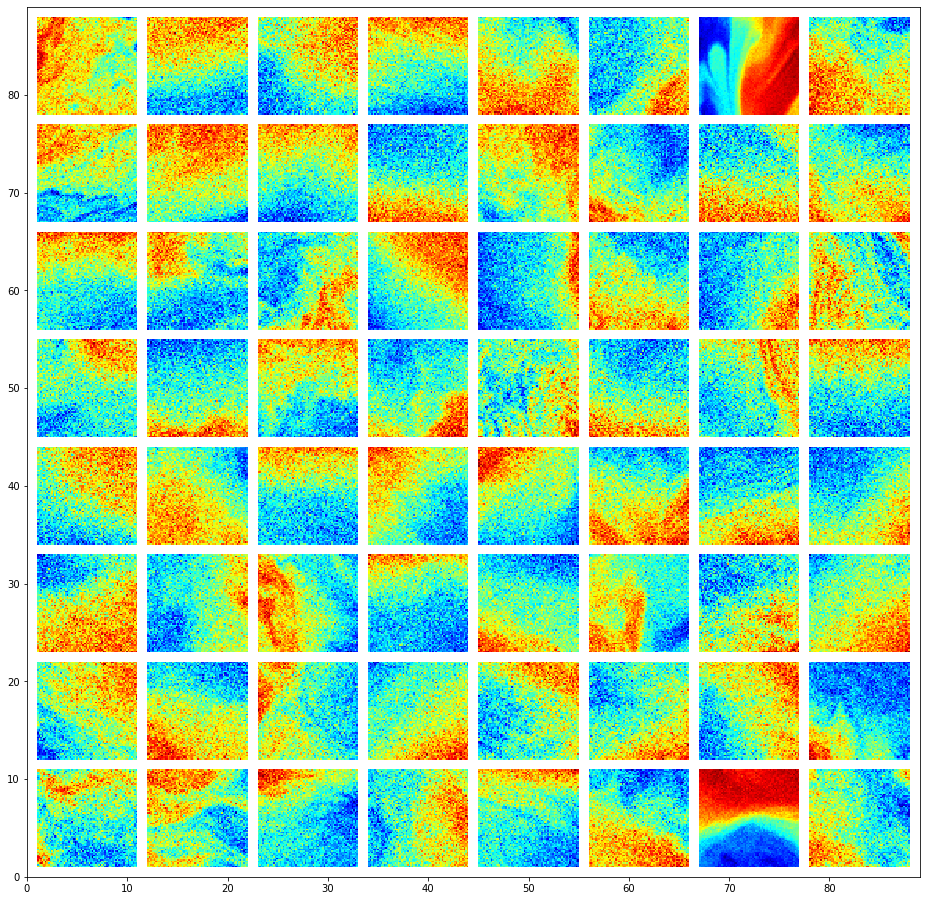

In [95]:
neighbour_gallery_viz(llc_modis_2012, indices[0])

## Gallery with 256 images

In [98]:
nbrs = NearestNeighbors(n_neighbors=256, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

Wrote: ./256_cutouts.png


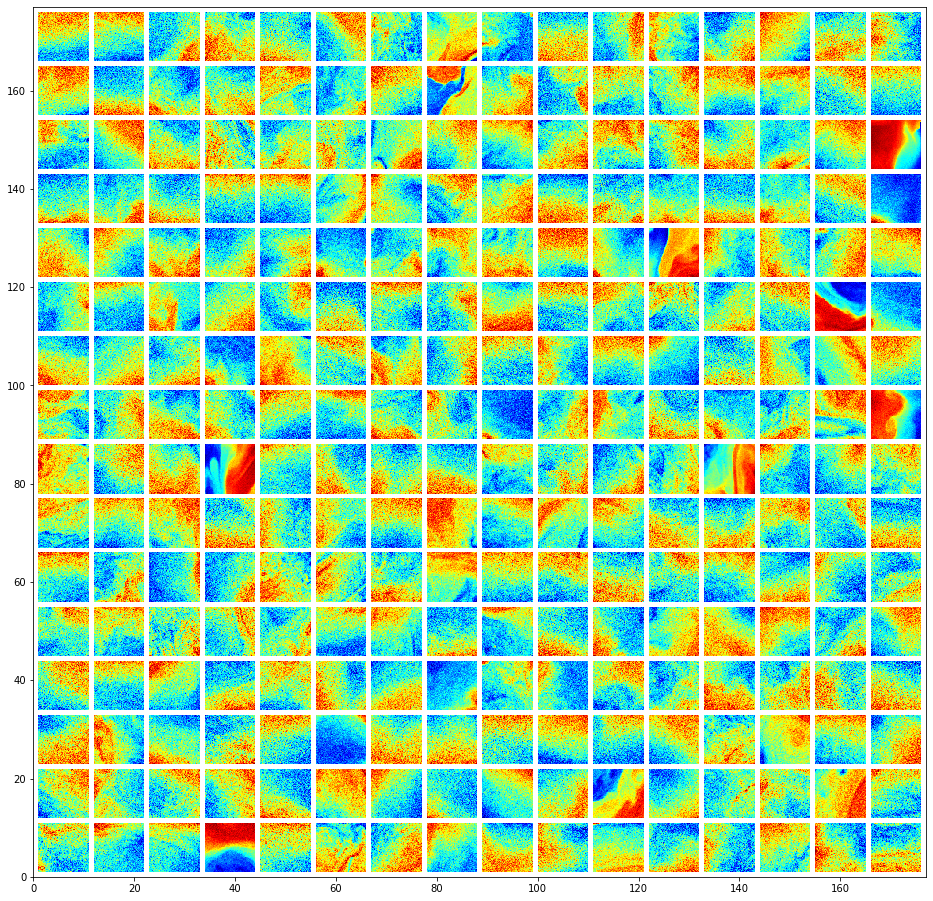

In [100]:
neighbour_gallery_viz(llc_modis_2012, indices[0], width=1600, height=1600, 
                          num_width=16, num_height=16, plt_show=True, outfile='./256_cutouts.png')

## Gallery with 1024 images

In [101]:
nbrs = NearestNeighbors(n_neighbors=1024, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

Wrote: ./1024_cutouts.png


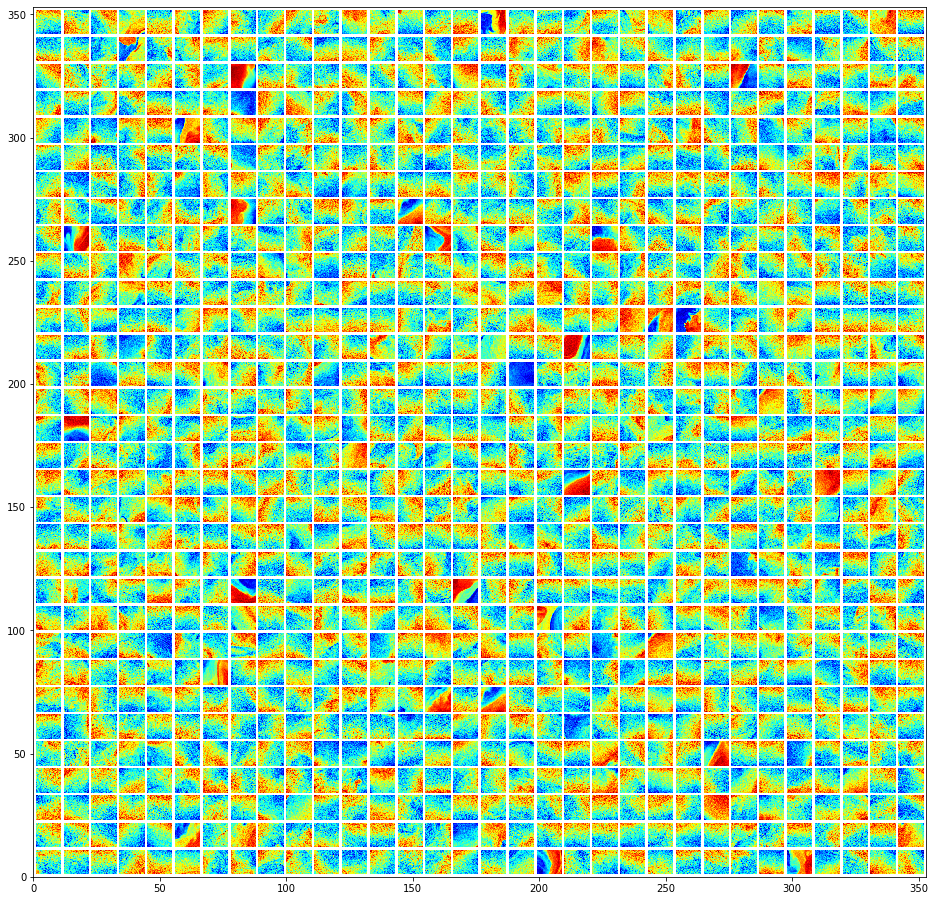

In [102]:
neighbour_gallery_viz(llc_modis_2012, indices[0], width=1600, height=1600, 
                          num_width=32, num_height=32, plt_show=True, outfile='./1024_cutouts.png')

In [105]:
### fix seed
np.random.seed(0)
indice_sampled = np.random.choice(indices.shape[0], 5)
indice_sets = indices[indice_sampled]
dist_sets = distances[indice_sampled]

Wrote: ./1024_cutouts_3.png


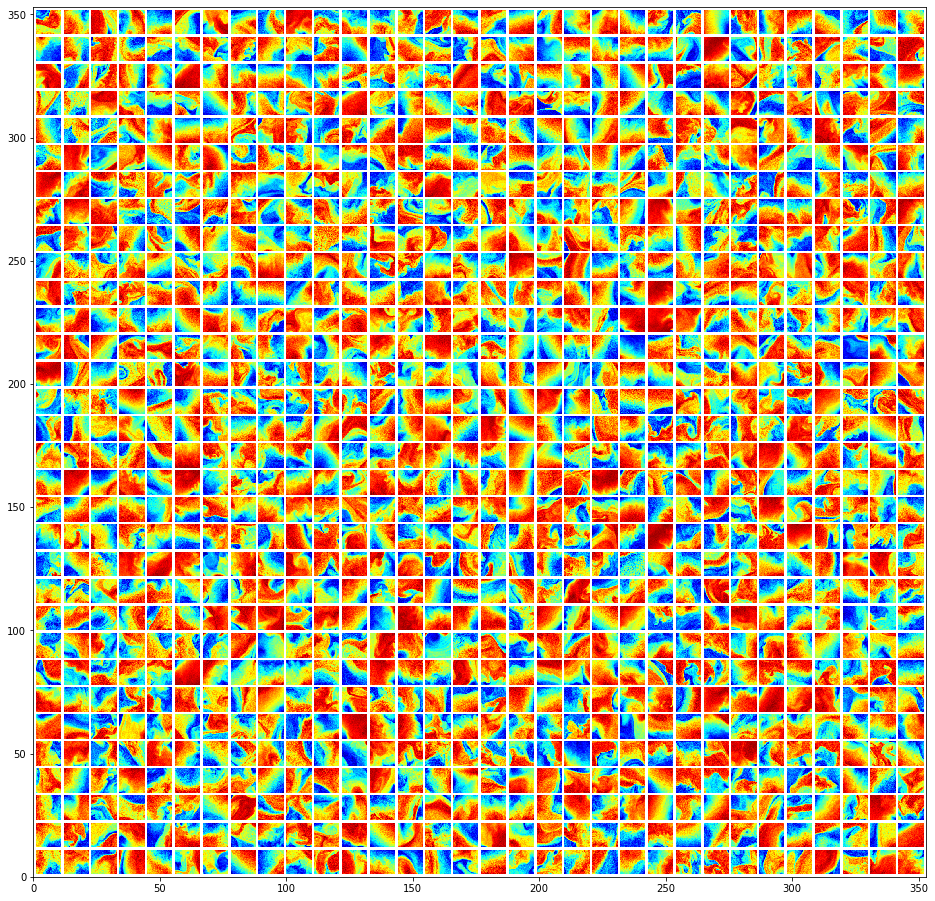

In [107]:
neighbour_gallery_viz(llc_modis_2012, indice_sets[2], width=1600, height=1600, 
                      num_width=32, num_height=32, plt_show=True, outfile='./1024_cutouts_3.png')

## Similarity Computation of 64 Cutouts

In [110]:
from sklearn.metrics.pairwise import cosine_similarity

In [108]:
nbrs = NearestNeighbors(n_neighbors=64, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [129]:
latents_64 = latents_llc_modis_2012[indices[0]]

In [130]:
sim_64 = cosine_similarity(latents_64)

In [131]:
col_min = sim_64.argmin() % 64 + 1
row_min = sim_64.argmin() // 64 + 1
print(col_min)
print(row_min)

59
16


In [153]:
latents_list = [latents_64[col_min-1], latents_64[row_min-1]]
print(cosine_similarity(latents_list)[0][1])

-0.2535648


Text(0.5, 1.0, 'sim: -0.25')

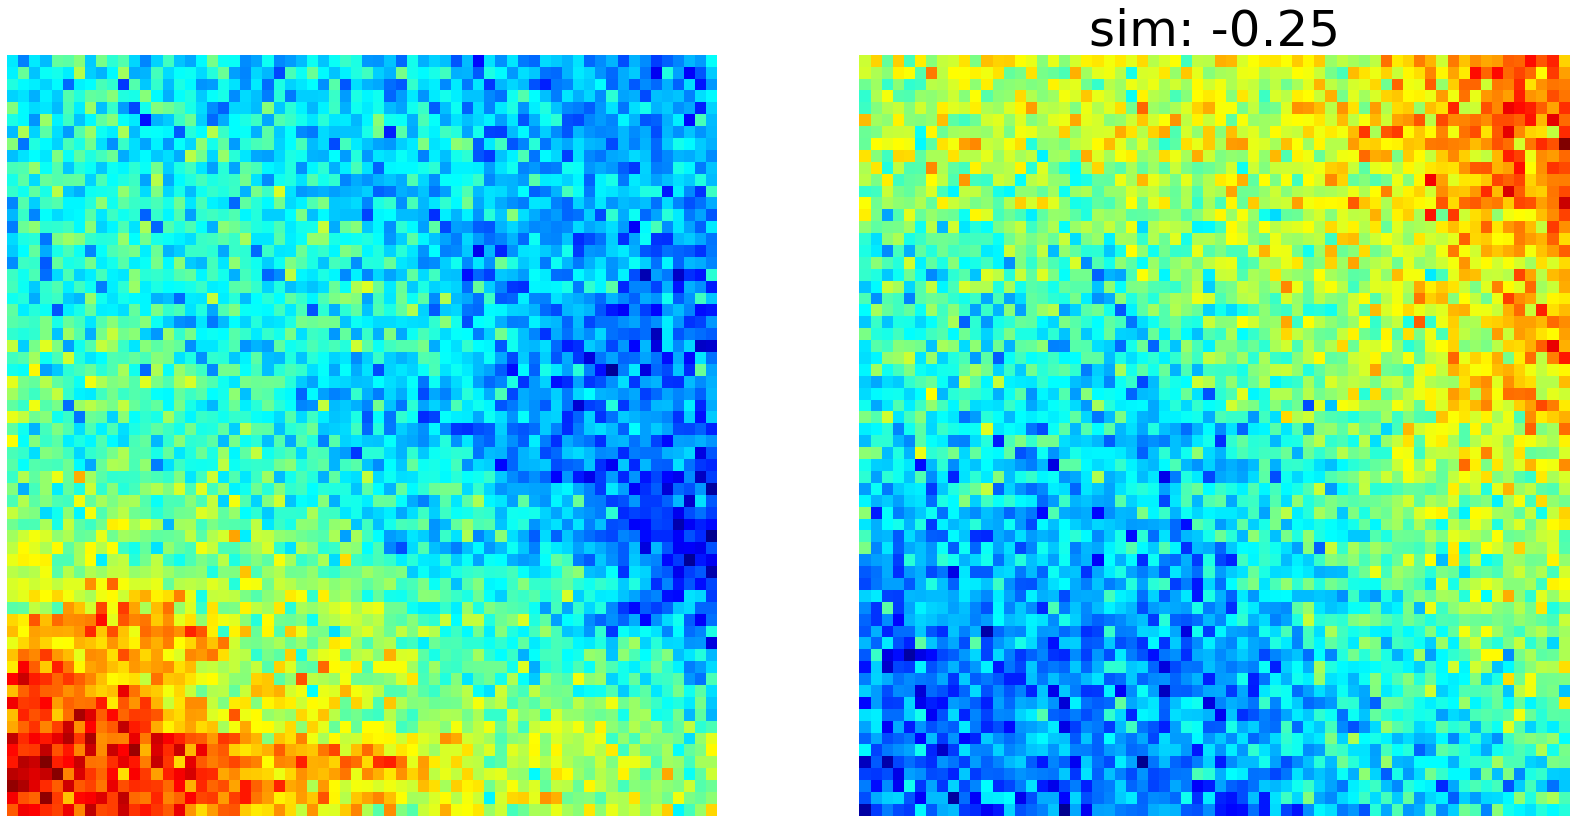

In [155]:
plt.figure(figsize=(28, 14))
plt.subplot(1, 2, 1)
sns.heatmap(llc_modis_2012[indices[0][16]][0], cmap=cm, 
                           cbar=False)
plt.axis('off')
plt.subplot(1, 2, 2)
sns.heatmap(llc_modis_2012[indices[0][59]][0], cmap=cm, 
                           cbar=False)
plt.axis('off')
sim = cosine_similarity(latents_list)[0][1]
plt.title(f'sim: {sim:.2f}', fontsize=50)

## Function to create the similarity gallery

In [250]:
def sim_gallery_viz(latents, width=1600, height=1600, 
                    num_width=8, num_height=8, plt_show=True, outfile=None):
    """
    This function is used to create the gallery of the images in a neighbourhood.
    Args:
        imgs_set: 
        idices:
        width:
        height:
        num_width:
        num_height:
    """
    # prepare the similarity vector
    sim_matrix = cosine_similarity(latents)
    sim_vector = sim_matrix.mean(axis=1)
    
    # plot the sim gallery
    dpi = 100
    plt.figure(figsize=(width//dpi, height//dpi))
    ax = plt.gca()
    dxdy=(5, 5)
    xmin, xmax = 0, 11 * num_width + 1
    ymin, ymax = 0, 11 * num_height + 1
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    _, cm = load_palette()
    for idx in range(num_width):
        for idy in range(num_height):
            sim = sim_vector[idx*num_height + idy]
            sim_img = np.ones((64, 64)) * sim
            xmin = idx * 11
            ymin = idy * 11
            axins = ax.inset_axes(
                [xmin+1, ymin+1, 10, 10], 
                transform=ax.transData)
            _ = sns.heatmap(np.flipud(sim_img), xticklabels=[], 
                yticklabels=[], cmap='hot', cbar=False, ax=axins, vmin=0.0, vmax=1.0)
    if outfile is not None:
        plt.savefig(outfile, dpi=300)
        print(f"Wrote: {outfile}")
    if plt_show:
        plt.show()

In [251]:
latents_64 = latents_llc_modis_2012[indices[0]]

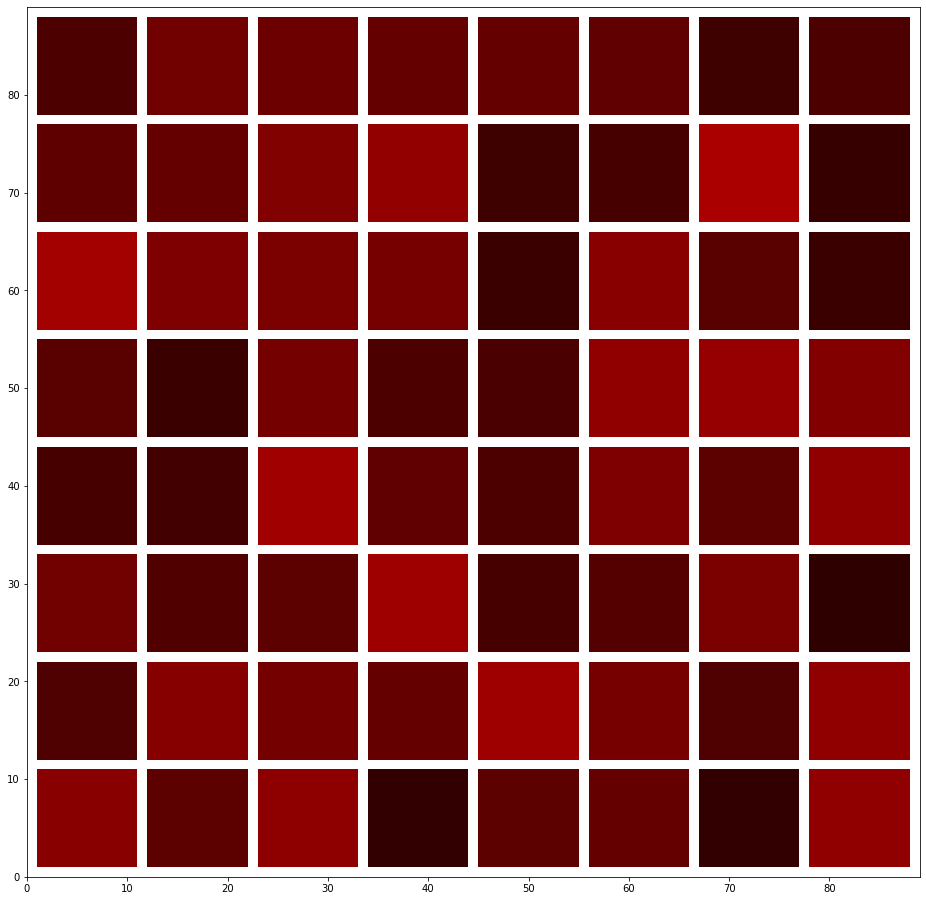

In [252]:
sim_gallery_viz(latents_64)

## Similarity Gallery of the 256 cutouts

In [253]:
nbrs = NearestNeighbors(n_neighbors=256, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [254]:
latents_256 = latents_llc_modis_2012[indices[0]]

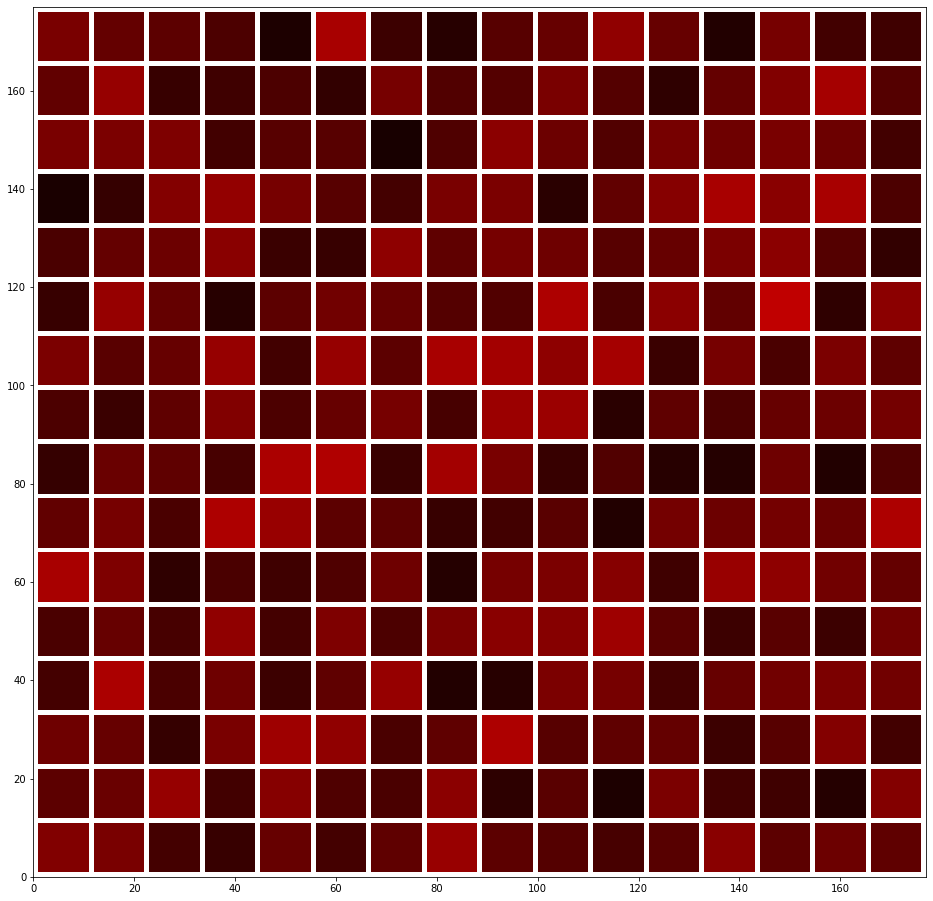

In [255]:
sim_gallery_viz(latents_256, width=1600, height=1600, 
                num_width=16, num_height=16, plt_show=True, outfile=None)

## Similarity Gallery of the 1024 cutouts

In [256]:
nbrs = NearestNeighbors(n_neighbors=1024, algorithm='ball_tree').fit(latents_reduced)
distances, indices = nbrs.kneighbors(latents_reduced)

In [257]:
latents_1024 = latents_llc_modis_2012[indices[0]]

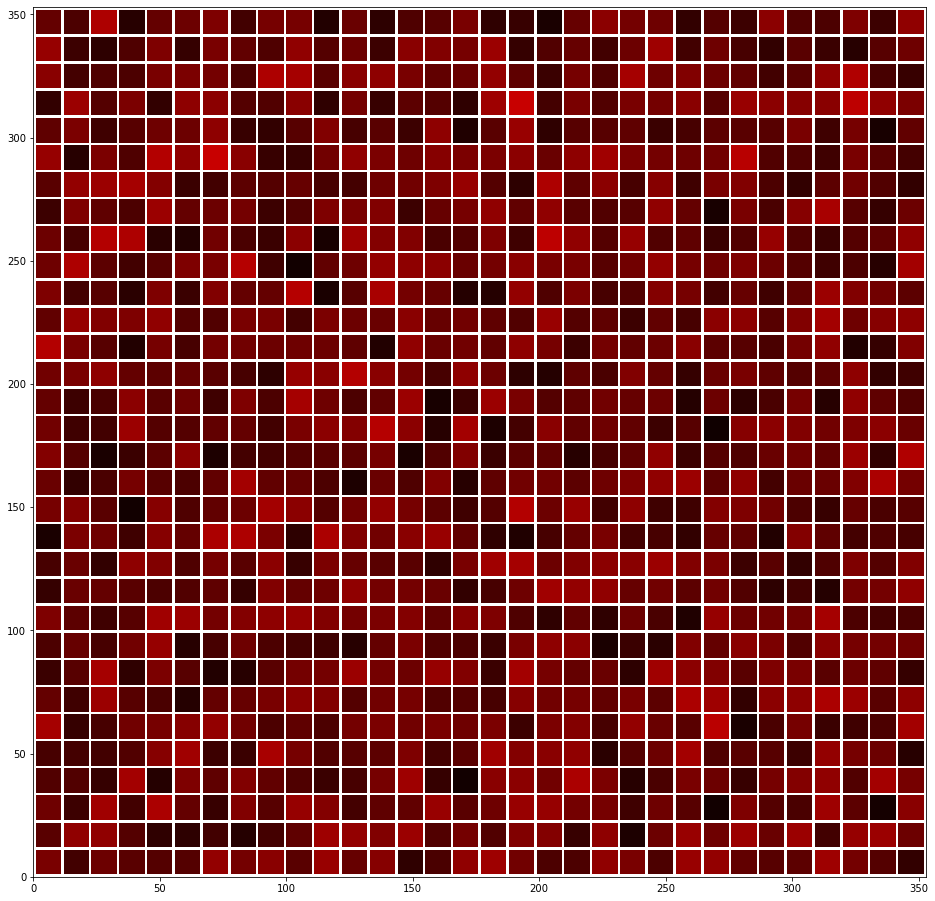

In [259]:
sim_gallery_viz(latents_1024, width=1600, height=1600, 
                num_width=32, num_height=32, plt_show=True)